# Running the nonadiabatic molecular dynamics (NA-MD)

In this tutorial, we conduct NBRA NA-MD calculations using the `tsh_revision` branch of the Libra code. This version implements the generic dynamical approach that is common to model-based NA-MD simulations and the one based on reading files. In this particular case, we setup the interface to pre-computed energy and time-overlap files (as could be produced by any codes) and use it in the generic dynamical workflow.

## Table of contents
<a name="toc"></a>
1. [Importing needed libraries](#import)
2. [Read the files](#2)
3. [Define the interface](#3)
4. [Define parameters and run the calculations](#4) 
5. [Plot the results](#5)

### A. Learning objectives

* To set up and run file-based NBRA NA-MD calculations

### B. Use cases

* [Construct the vibronic Hamiltonian from eQE MD files](#use_case-1)
* [Read the vibronic Hamiltonian data files to obtain its properties](#use_case-2)
* [Define adiabatic file-based model Hamiltonian](#use_case-3)
* [Compute nonadiabatic dynamics for atomistic systems with NBRA using Kohn-Sham states](#use_case-4)

### C. Functions

- `libra_py`
  - `dynamics`
    - `tsh`
      - `compute`
        - [`generic_recipe`](#generic_recipe-1)
      - `plot`
        - [`plot_dynamics`](#plot_dynamics-1)
  - `data_conv`
    - [`nparray2CMATRIX`](#nparray2CMATRIX-1)
    

## 1. Importing needed libraries <a name="1"></a>
[Back to TOC](#toc)

First, let's import all necessary libraries and define parameters such as colors

In [1]:
import matplotlib.pyplot as plt   # plots
import numpy as np
import warnings

from liblibra_core import *
import util.libutil as comn
from libra_py import units
from libra_py import data_conv
from libra_py import dynamics_plotting
import libra_py.dynamics.tsh.compute as tsh_dynamics
import libra_py.dynamics.tsh.plot as tsh_dynamics_plot
import libra_py.data_savers as data_savers

#from matplotlib.mlab import griddata
#%matplotlib inline 
warnings.filterwarnings('ignore')

colors = {}
colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   
colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      
colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  
colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]


/home/alexvakimov/SOFTWARE/Conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexvakimov/SOFTWARE/Conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexvakimov/SOFTWARE/Conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vect

## 2. Read the files <a name="2"></a>
[Back to TOC](#toc)

This is kinda not the best practice, but let's define some global variables - they will be matrices containing all energies and time-overlaps.

First, setup user-controlled parameters:

In [2]:
istep = 1    # the first timestep to read
fstep =200   # the last timestep to read
dt = 20.0    # integration time-step [a.u. of time]

All necessary data files for this tutorial are given in the `data.tar.bz2` file.

First, unpack it if you haven't done it yet:

    tar -xjf data.tar.bz2
    
This will create the `data` folder. The `E_*` files contain energies, and the `S_*` files contain time-overlaps.

We read them below
<a name="use_case-1"></a><a name="use_case-2"></a>

In [3]:
!tar -xjf data.tar.bz2

In [4]:
nsteps = fstep - istep
NSTEPS = nsteps
print(F"Number of steps = {nsteps}")

x = np.loadtxt(F'data/E_1_1_1_re')
nstates = x.shape[0]
NSTATES = nstates 
print(F"Number of states = {nstates}")

#================== Read energies =====================
E = np.zeros( (nsteps, nstates) )
for step in range(istep,fstep):        
    energy_filename = F'data/E_{step}_1_1_re'       
    E[step-1, :] = np.loadtxt(energy_filename)        

#================== Read time-overlap =====================
St = np.zeros( (nsteps, nstates, nstates) )
for step in range(istep,fstep):        
    energy_filename = F'data/S_{step}_0_1_tre'       
    St[step-1, :, :] = np.loadtxt(energy_filename)[5:5+nstates, 5:5+nstates]

#================ Compute NACs and vibronic Hamiltonians along the trajectory ============    
NAC = np.zeros( (nsteps, nstates, nstates) )
Hvib = [] 
for step in range(istep,fstep):        
    nac = 0.5*(St[step-1, :, :] - St[step-1, :, :].T)/dt
    NAC[step-1, :, :] = nac    
    Hvib.append( np.diag(E[step-1, :])*(1.0+1j*0.0)  - (0.0+1j)*nac[:, :] )  #    
Hvib = np.array(Hvib)

Number of steps = 199
Number of states = 12


## 3. Define the interface <a name="3"></a>
[Back to TOC](#toc)

The interface function should be defined as explained in other tutorials. It should return objects with the specifically-named data members. This is what we defined here:
<a name="nparray2CMATRIX-1"></a><a name="use_case-3"></a>

In [5]:
class tmp:
    pass

def compute_model(q, params, full_id):
    timestep = params["timestep"]
    nst = params["nstates"]
    obj = tmp()

    obj.ham_adi = data_conv.nparray2CMATRIX( np.diag(E[timestep, : ]) )    
    obj.nac_adi = data_conv.nparray2CMATRIX( NAC[timestep, :, :] )    
    obj.hvib_adi = data_conv.nparray2CMATRIX( Hvib[timestep, :, :] )    
    obj.basis_transform = CMATRIX(nst,nst); obj.basis_transform.identity()  #basis_transform
    obj.time_overlap_adi = data_conv.nparray2CMATRIX( St[timestep, :, :] )   
            
    return obj


## 4. Define parameters and run the calculations <a name="4"></a>
[Back to TOC](#toc)

Make sure you define all of these 4 parameters of the `model_params` dictionary

In [6]:
#================== Model parameters ====================
model_params = { "timestep":0, "icond":0,  "model0":0, "nstates":NSTATES }

Dynamics control parameters

In [7]:
#=============== Some automatic variables, related to the settings above ===================

dyn_general = { "nsteps":NSTEPS, "ntraj":25, "nstates":NSTATES, "dt":dt,                                                 
                "decoherence_rates":MATRIX(NSTATES,NSTATES), "ave_gaps":MATRIX(NSTATES,NSTATES),                
                "progress_frequency":0.1, "which_adi_states":range(NSTATES), "which_dia_states":range(NSTATES),
                "mem_output_level":2,
                "properties_to_save":[ "timestep", "time","se_pop_adi", "sh_pop_adi" ],
                "prefix":F"NBRA", "prefix2":F"NBRA", "isNBRA":0
              }

#=========== Some NBRA-specific parameters - these are the key settings for running file-based NBRA calculations ===========

dyn_general.update({"ham_update_method":2})  # read adiabatic properties from mthe files

dyn_general.update({"ham_transform_method":0})  # don't attempt to compute adiabatic properties from the diabatic ones, not to
                                                # override the read ones 
    
dyn_general.update({"time_overlap_method":0})  # don't attempt to compute those, not to override the read ones

dyn_general.update({"nac_update_method":0})    # don't attempt to recompute NACs, so that we don't override the read values

dyn_general.update({"hvib_update_method":0})   # don't attempt to recompute Hvib, so that we don't override the read values


dyn_general.update( {"force_method":0, "rep_force":1} ) # NBRA = don't compute forces, so rep_force actually doesn't matter


dyn_general.update({"hop_acceptance_algo":32, "momenta_rescaling_algo":0 })  # accept based on Boltzmann, no velocity rescaling

dyn_general.update( {"rep_tdse":1}) # the TDSE integration is conducted in adiabatic rep

dyn_general.update( {"electronic_integrator":2} )  # using the local diabatization approach to integrate TD-SE



#============ Surface hopping opntions =================
dyn_general.update({"tsh_method":0 }) # FSSH
dyn_general.update({ "decoherence_algo":-1}) # no (additional) decoherence
dyn_general.update({"decoherence_times_type":-1 }) # No decoherence times, infinite decoherence times
dyn_general.update({"do_ssy":0 }) # do no use Shenvi-Subotnik-Yang phase correction
dyn_general.update( {"dephasing_informed":0} ) # no dephasing-informed correction


In [8]:
#=================== Dynamics =======================
# Nuclear DOF - these parameters don't matter much in the NBRA calculations
nucl_params = {"ndof":1, "init_type":3, "q":[-10.0], "p":[0.0], "mass":[2000.0], "force_constant":[0.01], "verbosity":-1 }

# Amplitudes are sampled
elec_params = {"ndia":NSTATES, "nadi":NSTATES, "verbosity":-1, "init_dm_type":0}


elec_params.update( {"init_type":1,  "rep":1,  "istate":11 } )  # how to initialize: random phase, adiabatic representation, given initial state

Finally run the calculations
<a name="generic_recipe-1"></a><a name="use_case-4"></a>

In [9]:
rnd = Random()

res = tsh_dynamics.generic_recipe(dyn_general, compute_model, model_params, elec_params, nucl_params, rnd)

 step= 0
In cctor: lv step= 19
 step= 38
 step= 57
 step= 76
 step= 95
 step= 114
 step= 133
 step= 152
 step= 171
 step= 190
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data


## 5. Plot the results<a name="5"></a>
[Back to TOC](#toc)
<a name="plot_dynamics-1"></a>

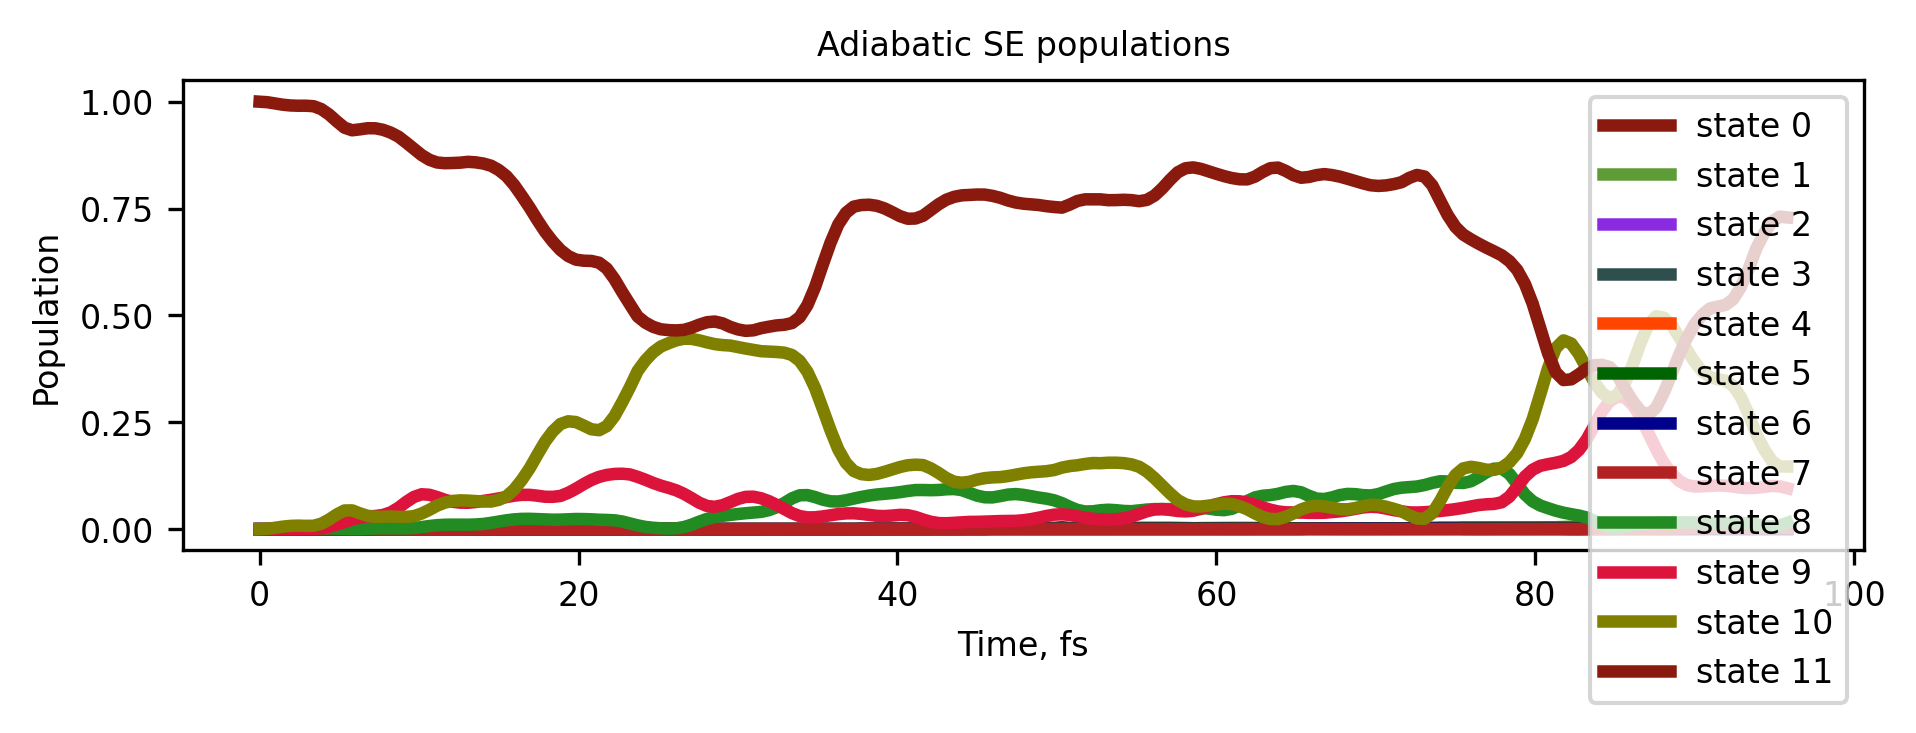

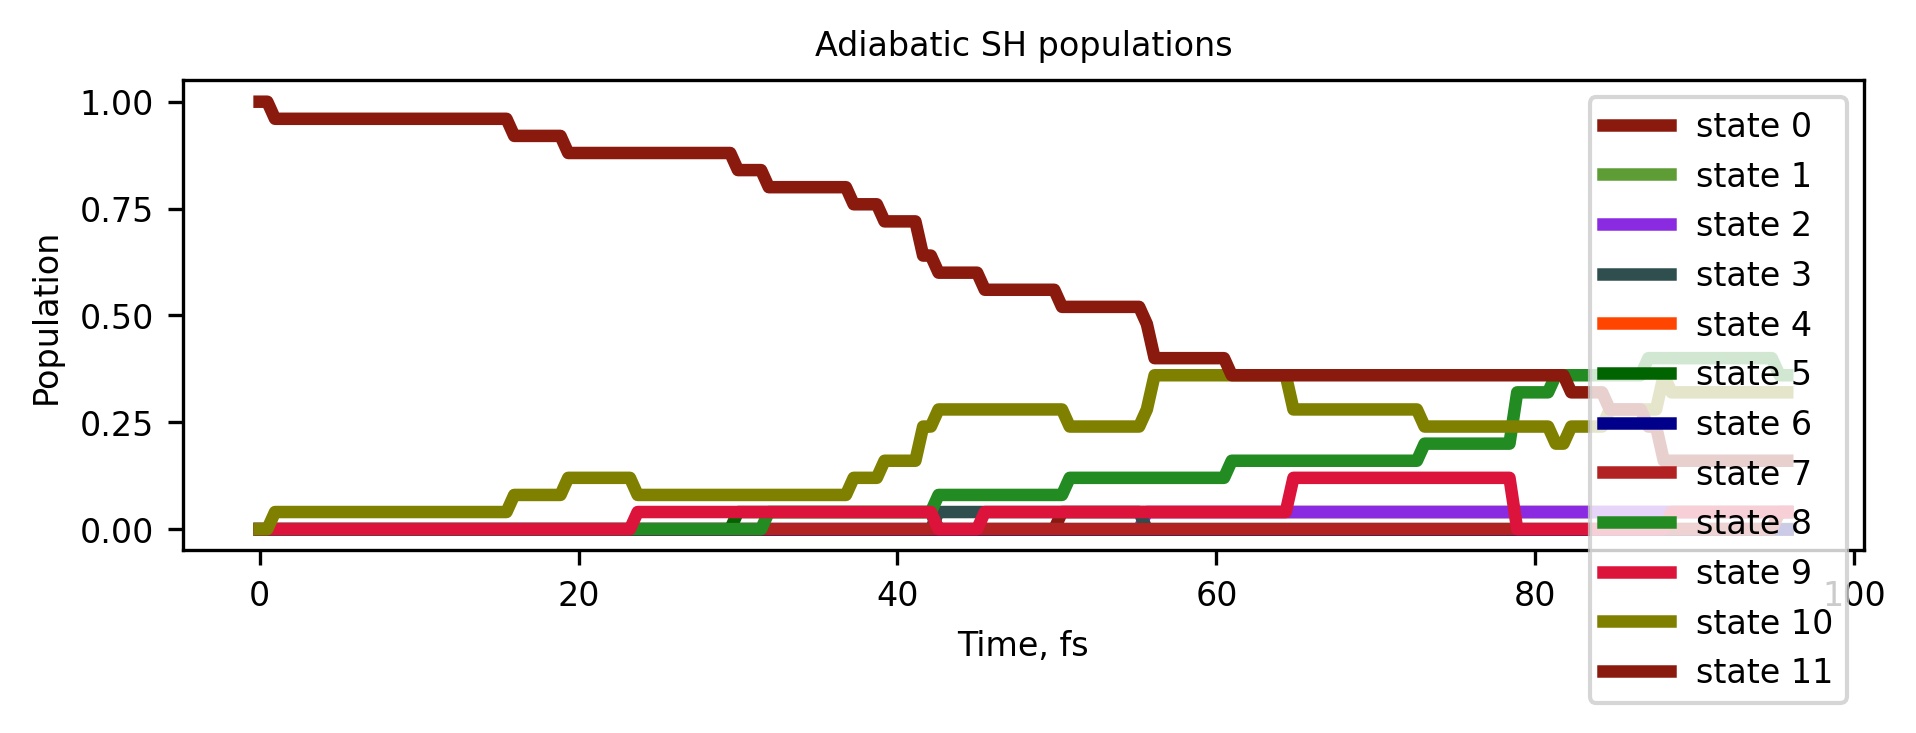

In [10]:
pref = "NBRA"

nst = model_params["nstates"]
ntraj = dyn_general["ntraj"]

plot_params = { "prefix":pref, "filename":"mem_data.hdf", "output_level":2,
                "which_trajectories":list(range(ntraj)), "which_dofs":[0], "which_adi_states":list(range(nst)), 
                "which_dia_states":list(range(nst)), 
                "frameon":True, "linewidth":3, "dpi":300,
                "axes_label_fontsize":(8,8), "legend_fontsize":8, "axes_fontsize":(8,8), "title_fontsize":8,
                "what_to_plot":["se_pop_adi", "sh_pop_adi" ], 
                "which_energies":["potential", "kinetic", "total"],
                "save_figures":1, "do_show":1
              }

tsh_dynamics_plot.plot_dynamics(plot_params)